In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.auto import tqdm
from collections import deque
import warnings
warnings.filterwarnings("ignore")



# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
OBO_PATH = "/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo"
SUBMISSION_INPUT = "/kaggle/input/cafa6-protein-function-enhanced-nb-v2/submission.tsv"
SUBMISSION_OUTPUT = "submission.tsv"

MIN_SCORE_THRESHOLD = 0.01     # post-propagation cutoff
MAX_PROP_DEPTH = 8             # prevents root flooding
PART_OF_WEIGHT = 0.7           # softer than is_a

# ---------------------------------------------------------
# 1. BUILD GO GRAPH (child -> parents + weights)
# ---------------------------------------------------------
def build_go_graph(go_obo_path):
    if not os.path.exists(go_obo_path):
        raise FileNotFoundError(go_obo_path)

    parent_map = {}
    edge_weight = {}

    with open(go_obo_path, "r") as f:
        cur = None
        for line in f:
            line = line.strip()

            if line == "[Term]":
                cur = None

            elif line.startswith("id: "):
                cur = line.split("id: ")[1]
                parent_map.setdefault(cur, [])

            elif line.startswith("is_a: ") and cur:
                p = line.split()[1]
                parent_map[cur].append(p)
                edge_weight[(cur, p)] = 1.0

            elif line.startswith("relationship: part_of ") and cur:
                p = line.split()[2]
                parent_map[cur].append(p)
                edge_weight[(cur, p)] = PART_OF_WEIGHT

    print(f"✓ Loaded GO graph with {len(parent_map):,} terms")
    return parent_map, edge_weight

# ---------------------------------------------------------
# 2. FAST BFS HARD-MAX PROPAGATION (SAFE)
# ---------------------------------------------------------
def propagate_hard_max(df, parent_map, edge_weight):
    final_rows = []

    for pid, group in tqdm(df.groupby("protein_id"), desc="Propagating"):
        scores = dict(zip(group.go_term, group.score))
        depth = {k: 0 for k in scores}

        queue = deque(scores.items())

        while queue:
            term, score = queue.popleft()
            d = depth[term]

            if d >= MAX_PROP_DEPTH or score < MIN_SCORE_THRESHOLD:
                continue

            for parent in parent_map.get(term, ()):
                new_score = score * edge_weight[(term, parent)]
                new_score = min(1.0, new_score)  # clamp

                if new_score > scores.get(parent, 0.0):
                    scores[parent] = new_score
                    depth[parent] = d + 1
                    queue.append((parent, new_score))

        for term, score in scores.items():
            if score >= MIN_SCORE_THRESHOLD:
                final_rows.append((pid, term, score))

    return pd.DataFrame(final_rows, columns=["protein_id", "go_term", "score"])

# ---------------------------------------------------------
# 3. RUN PIPELINE
# ---------------------------------------------------------
print(" Building GO graph...")
parent_map, edge_weight = build_go_graph(OBO_PATH)

print(" Loading submission...")
submission = pd.read_csv(
    SUBMISSION_INPUT,
    sep="\t",
    header=None,
    names=["protein_id", "go_term", "score"],
    dtype={"score": np.float32},
    on_bad_lines="skip"
)

print(f"✓ Loaded {len(submission):,} rows")

print(" Propagating scores...")
submission_improved = propagate_hard_max(
    submission, parent_map, edge_weight
)

print("Saving submission...")

submission_improved["score"] = (
    submission_improved["score"]
    .clip(0.0, 1.0)
    .round(3)
)

submission_improved.to_csv(
    SUBMISSION_OUTPUT,
    sep="\t",
    index=False,
    header=False
)

print(f"✓ DONE | Saved {len(submission_improved):,} rows")
print(submission_improved.head())


 Building GO graph...
✓ Loaded GO graph with 48,106 terms
 Loading submission...
✓ Loaded 40,796,692 rows
 Propagating scores...


Propagating:   0%|          | 0/279437 [00:00<?, ?it/s]

Saving submission...
✓ DONE | Saved 55,554,366 rows
   protein_id     go_term  score
0  A0A009IHW8  GO:0003953    1.0
1  A0A009IHW8  GO:0007165    1.0
2  A0A009IHW8  GO:0016787    1.0
3  A0A009IHW8  GO:0019677    1.0
4  A0A009IHW8  GO:0050135    1.0


Starting GO propagation pipeline...
Building GO graph...
✓ Loaded GO graph with 48,106 terms
Loading submission...
✓ Loaded 40,796,692 rows for 279,437 proteins
Propagating scores...
Propagating for 279,437 proteins...


Propagating:   0%|          | 0/279437 [00:00<?, ?it/s]

✓ Propagation complete: 55,554,366 rows
✓ Saved propagated submission: 55,554,366 rows
Output: submission.tsv


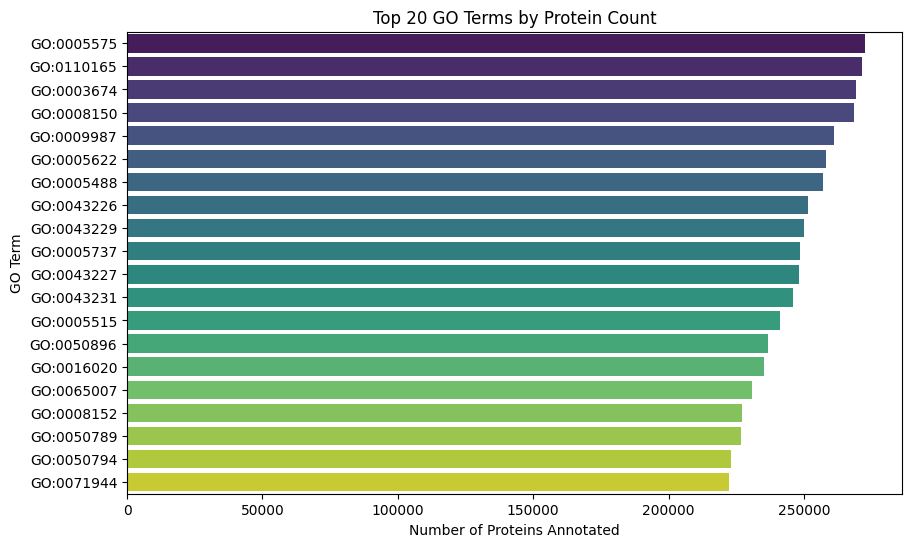

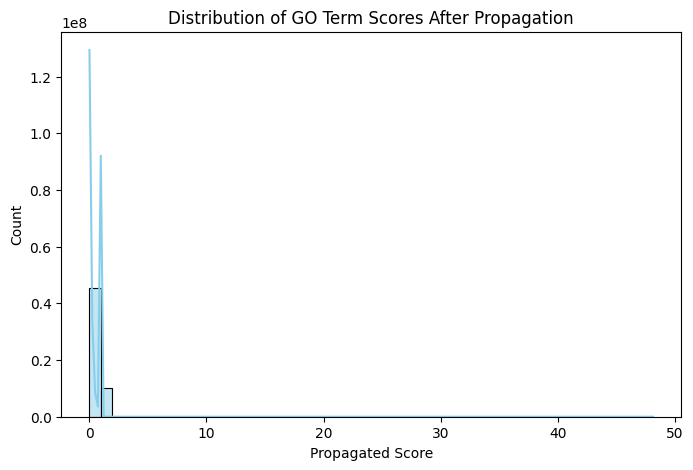

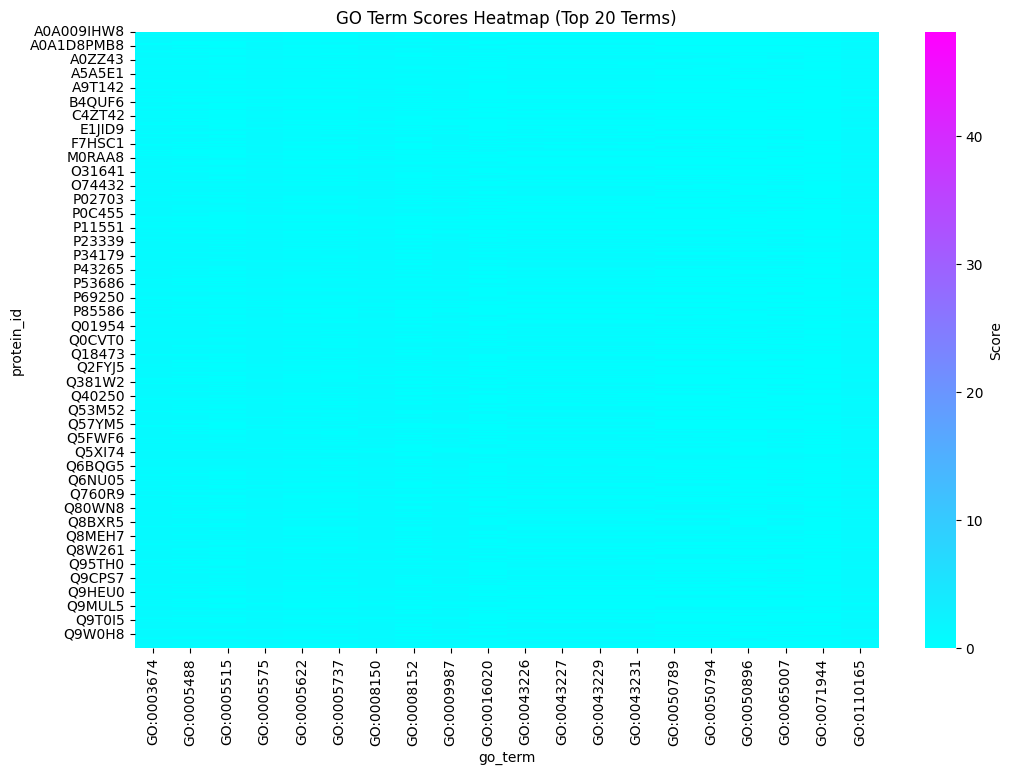

Pipeline complete with visual insights!


In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.auto import tqdm
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

print("Starting GO propagation pipeline...")

# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
OBO_PATH = "/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo"
SUBMISSION_INPUT = "/kaggle/input/cafa6-protein-function-enhanced-nb-v2/submission.tsv"
SUBMISSION_OUTPUT = "submission.tsv"

MIN_SCORE_THRESHOLD = 0.01     # post-propagation cutoff
MAX_PROP_DEPTH = 8             # prevents root flooding
PART_OF_WEIGHT = 0.7           # softer than is_a

# ---------------------------------------------------------
# 1. BUILD GO GRAPH
# ---------------------------------------------------------
def build_go_graph(go_obo_path):
    if not os.path.exists(go_obo_path):
        raise FileNotFoundError(go_obo_path)

    parent_map = {}
    edge_weight = {}

    with open(go_obo_path, "r") as f:
        cur = None
        for line in f:
            line = line.strip()

            if line == "[Term]":
                cur = None
            elif line.startswith("id: "):
                cur = line.split("id: ")[1]
                parent_map.setdefault(cur, [])
            elif line.startswith("is_a: ") and cur:
                p = line.split()[1]
                parent_map[cur].append(p)
                edge_weight[(cur, p)] = 1.0
            elif line.startswith("relationship: part_of ") and cur:
                p = line.split()[2]
                parent_map[cur].append(p)
                edge_weight[(cur, p)] = PART_OF_WEIGHT

    print(f"✓ Loaded GO graph with {len(parent_map):,} terms")
    return parent_map, edge_weight

# ---------------------------------------------------------
# 2. HARD-MAX BFS PROPAGATION
# ---------------------------------------------------------
def propagate_hard_max(df, parent_map, edge_weight):
    final_rows = []
    num_proteins = df.protein_id.nunique()
    print(f"Propagating for {num_proteins:,} proteins...")

    for pid, group in tqdm(df.groupby("protein_id"), desc="Propagating"):
        scores = dict(zip(group.go_term, group.score))
        depth = {k: 0 for k in scores}
        queue = deque(scores.items())

        while queue:
            term, score = queue.popleft()
            d = depth[term]

            if d >= MAX_PROP_DEPTH or score < MIN_SCORE_THRESHOLD:
                continue

            for parent in parent_map.get(term, ()):
                new_score = score * edge_weight[(term, parent)]
                new_score = min(1.0, new_score)

                if new_score > scores.get(parent, 0.0):
                    scores[parent] = new_score
                    depth[parent] = d + 1
                    queue.append((parent, new_score))

        for term, score in scores.items():
            if score >= MIN_SCORE_THRESHOLD:
                final_rows.append((pid, term, score))

    propagated_df = pd.DataFrame(final_rows, columns=["protein_id", "go_term", "score"])
    print(f"✓ Propagation complete: {len(propagated_df):,} rows")
    return propagated_df

# ---------------------------------------------------------
# 3. RUN PIPELINE
# ---------------------------------------------------------
print("Building GO graph...")
parent_map, edge_weight = build_go_graph(OBO_PATH)

print("Loading submission...")
submission = pd.read_csv(
    SUBMISSION_INPUT,
    sep="\t",
    header=None,
    names=["protein_id", "go_term", "score"],
    dtype={"score": np.float32},
    on_bad_lines="skip"
)
print(f"✓ Loaded {len(submission):,} rows for {submission.protein_id.nunique():,} proteins")

print("Propagating scores...")
submission_improved = propagate_hard_max(submission, parent_map, edge_weight)

# Round scores for submission
submission_improved["score"] = submission_improved["score"].round(3)

# Save submission
submission_improved.to_csv(
    SUBMISSION_OUTPUT,
    sep="\t",
    index=False,
    header=False
)
print(f"✓ Saved propagated submission: {len(submission_improved):,} rows")
print(f"Output: {SUBMISSION_OUTPUT}")

# ---------------------------------------------------------
# 4. INSIGHTS & VISUALIZATION
# ---------------------------------------------------------
# Top GO terms by frequency
top_terms = submission_improved['go_term'].value_counts().head(20)
plt.figure(figsize=(10,6))
sns.barplot(x=top_terms.values, y=top_terms.index, palette="viridis")
plt.xlabel("Number of Proteins Annotated")
plt.ylabel("GO Term")
plt.title("Top 20 GO Terms by Protein Count")
plt.show()

# Score distribution
plt.figure(figsize=(8,5))
sns.histplot(submission_improved['score'], bins=50, kde=True, color='skyblue')
plt.xlabel("Propagated Score")
plt.title("Distribution of GO Term Scores After Propagation")
plt.show()

# Proteins per GO term heatmap (top 30)
top_terms_list = top_terms.index
heatmap_df = submission_improved[submission_improved['go_term'].isin(top_terms_list)]
heatmap_pivot = heatmap_df.pivot_table(
    index='protein_id', columns='go_term', values='score', fill_value=0
)
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_pivot, cmap="cool", cbar_kws={'label':'Score'})
plt.title("GO Term Scores Heatmap (Top 20 Terms)")
plt.show()

print("Pipeline complete with visual insights!")

Summary of new GO terms added per protein:
count    279437.000000
mean         52.813818
std          41.693818
min           0.000000
25%          14.000000
50%          54.000000
75%          81.000000
max         650.000000
Name: go_term, dtype: float64


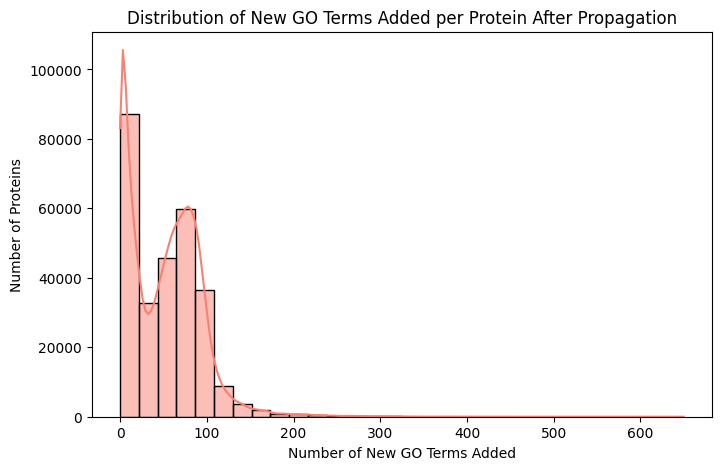

Top 10 proteins with most new GO terms added:
protein_id
P01137        650
P04202        631
P17246        613
P31750        593
P47196        579
P07200        533
A0A0G2JZ79    530
Q02248        521
P01375        517
Q9WU82        511
Name: go_term, dtype: int64


In [3]:
# ---------------------------------------------------------
# 5. NEW GO TERMS SUMMARY
# ---------------------------------------------------------
# Count original GO terms per protein
original_counts = submission.groupby('protein_id')['go_term'].nunique()
# Count propagated GO terms per protein
propagated_counts = submission_improved.groupby('protein_id')['go_term'].nunique()
# New GO terms added
new_terms_per_protein = propagated_counts - original_counts

print("Summary of new GO terms added per protein:")
print(new_terms_per_protein.describe())

# Plot new GO terms distribution
plt.figure(figsize=(8,5))
sns.histplot(new_terms_per_protein, bins=30, kde=True, color='salmon')
plt.xlabel("Number of New GO Terms Added")
plt.ylabel("Number of Proteins")
plt.title("Distribution of New GO Terms Added per Protein After Propagation")
plt.show()

# Proteins with maximum new terms added
top_new_terms = new_terms_per_protein.sort_values(ascending=False).head(10)
print("Top 10 proteins with most new GO terms added:")
print(top_new_terms)

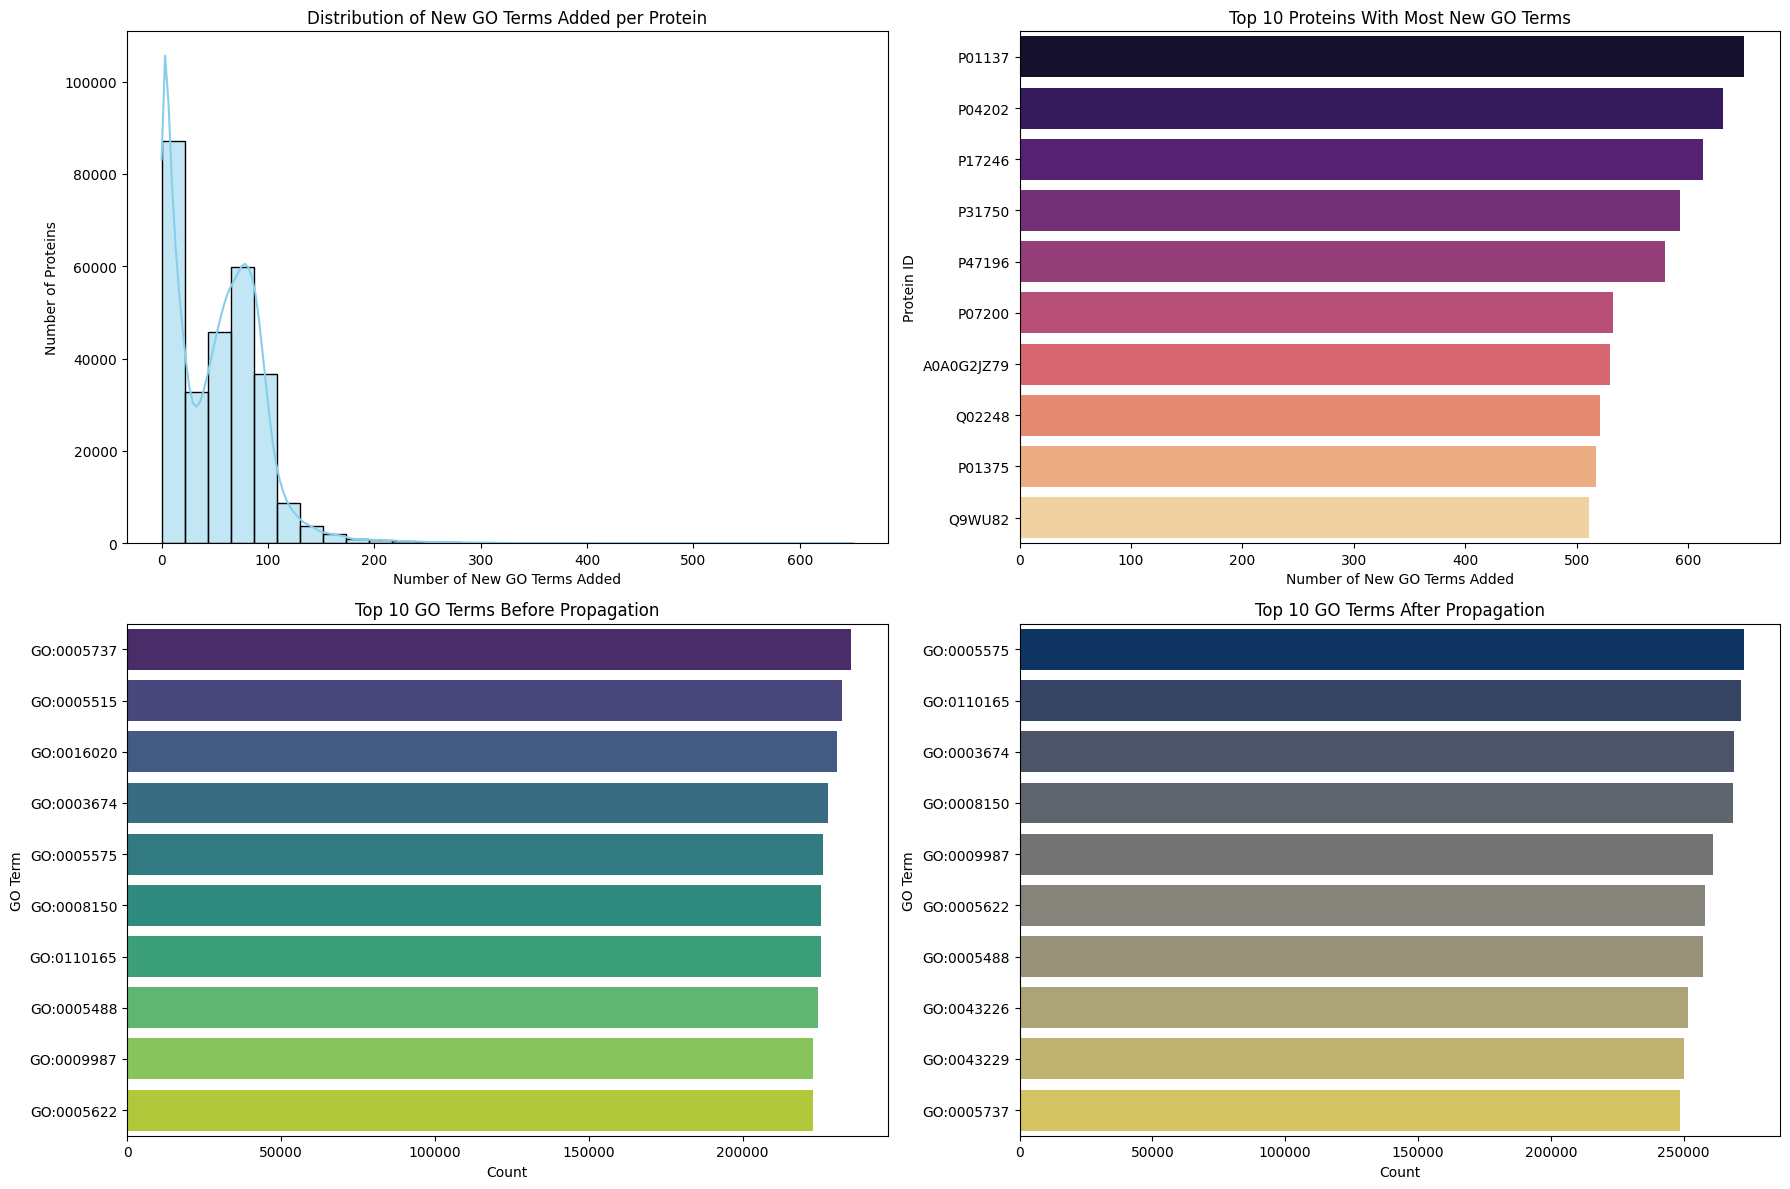

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# INSIGHTS DASHBOARD
# ---------------------------------------------------------

# 1️⃣ Distribution of original vs propagated GO terms per protein
original_counts = submission.groupby('protein_id')['go_term'].nunique()
propagated_counts = submission_improved.groupby('protein_id')['go_term'].nunique()
new_terms_per_protein = propagated_counts - original_counts

# 2️⃣ Top 10 proteins with most new GO terms
top_new_terms = new_terms_per_protein.sort_values(ascending=False).head(10)

# 3️⃣ Most frequent GO terms before and after propagation
top_terms_original = submission['go_term'].value_counts().head(10)
top_terms_propagated = submission_improved['go_term'].value_counts().head(10)

# Plotting
plt.figure(figsize=(18,12))

# --- Subplot 1: Histogram of new GO terms per protein ---
plt.subplot(2,2,1)
sns.histplot(new_terms_per_protein, bins=30, kde=True, color='skyblue')
plt.xlabel("Number of New GO Terms Added")
plt.ylabel("Number of Proteins")
plt.title("Distribution of New GO Terms Added per Protein")

# --- Subplot 2: Top 10 proteins with most new GO terms ---
plt.subplot(2,2,2)
sns.barplot(x=top_new_terms.values, y=top_new_terms.index, palette='magma')
plt.xlabel("Number of New GO Terms Added")
plt.ylabel("Protein ID")
plt.title("Top 10 Proteins With Most New GO Terms")

# --- Subplot 3: Top GO terms before propagation ---
plt.subplot(2,2,3)
sns.barplot(x=top_terms_original.values, y=top_terms_original.index, palette='viridis')
plt.xlabel("Count")
plt.ylabel("GO Term")
plt.title("Top 10 GO Terms Before Propagation")

# --- Subplot 4: Top GO terms after propagation ---
plt.subplot(2,2,4)
sns.barplot(x=top_terms_propagated.values, y=top_terms_propagated.index, palette='cividis')
plt.xlabel("Count")
plt.ylabel("GO Term")
plt.title("Top 10 GO Terms After Propagation")

plt.tight_layout()
plt.show()

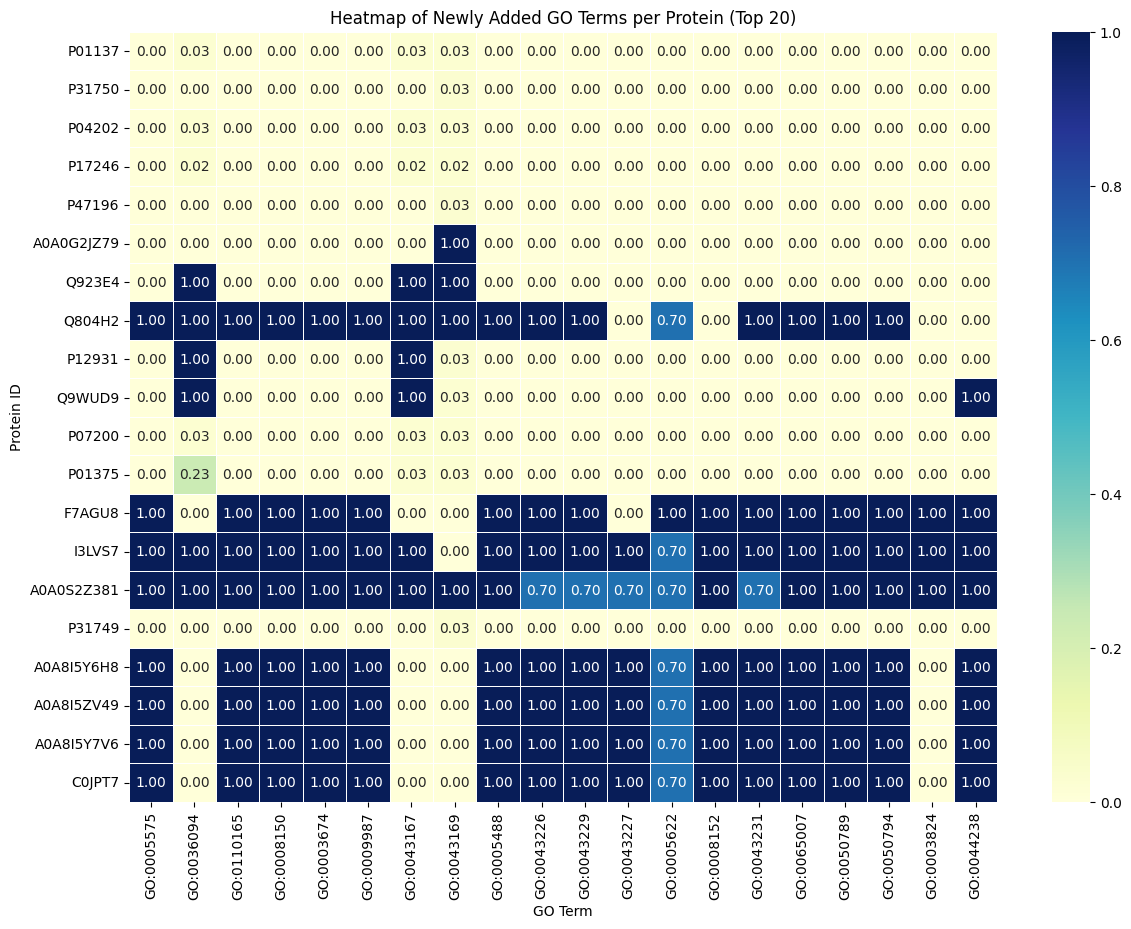

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# HEATMAP OF PROTEINS vs GO TERMS (Newly Added Terms)
# ---------------------------------------------------------

# Identify newly added GO terms
new_terms = submission_improved.merge(
    submission, 
    on=['protein_id', 'go_term'], 
    how='left', 
    indicator=True
)

# Keep only the rows that exist in submission_improved but not in submission
new_terms = new_terms[new_terms['_merge'] == 'left_only']

# Ensure the correct score column is used
if 'score_x' in new_terms.columns:
    new_terms.rename(columns={'score_x':'score'}, inplace=True)
elif 'score_y' in new_terms.columns:
    new_terms.rename(columns={'score_y':'score'}, inplace=True)

# Check if there are any new terms
if len(new_terms) == 0:
    print("No new GO terms to plot!")
else:
    # Pivot table for heatmap (rows=protein_id, cols=GO terms)
    heatmap_data = new_terms.pivot_table(
        index='protein_id',
        columns='go_term',
        values='score',
        fill_value=0
    )

    # Limit to top N proteins/GO terms for visibility
    TOP_PROTEINS = 20
    TOP_GO_TERMS = 20

    top_proteins = heatmap_data.sum(axis=1).sort_values(ascending=False).head(TOP_PROTEINS).index
    top_go_terms = heatmap_data.sum(axis=0).sort_values(ascending=False).head(TOP_GO_TERMS).index
    heatmap_subset = heatmap_data.loc[top_proteins, top_go_terms]

    # Plot heatmap
    plt.figure(figsize=(14,10))
    sns.heatmap(heatmap_subset, cmap='YlGnBu', linewidths=0.5, annot=True, fmt=".2f")
    plt.title("Heatmap of Newly Added GO Terms per Protein (Top 20)")
    plt.xlabel("GO Term")
    plt.ylabel("Protein ID")
    plt.show()

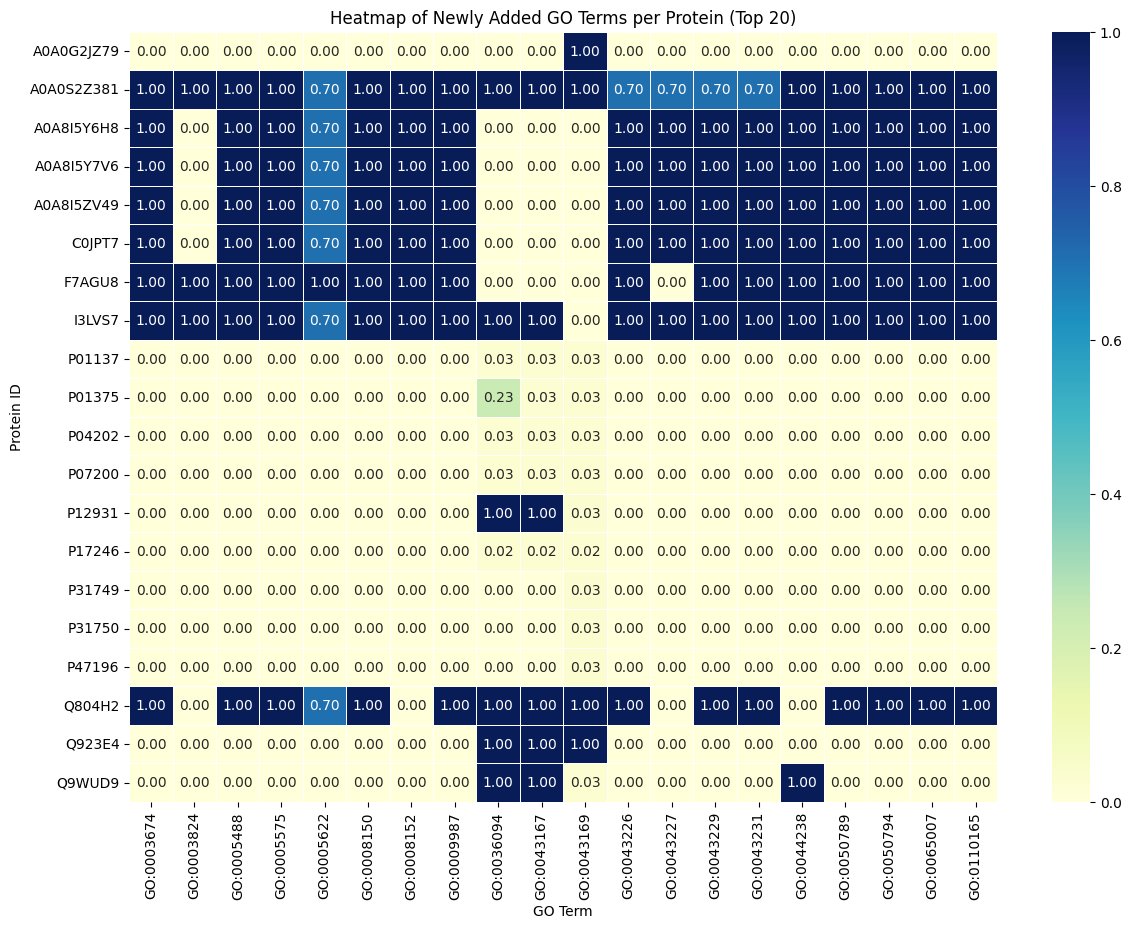

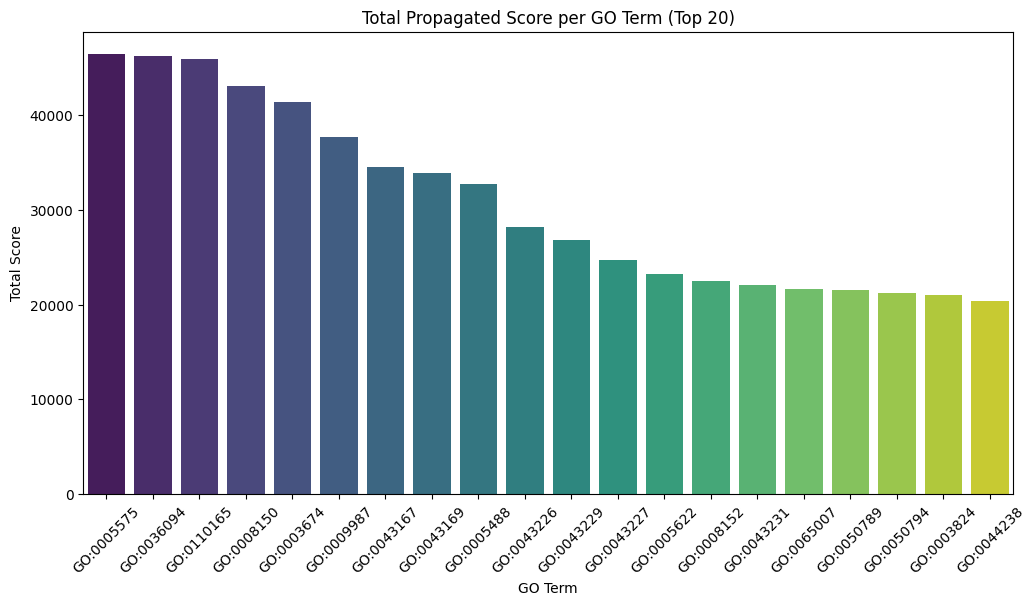

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top proteins/GO terms
TOP_PROTEINS = 20
TOP_GO_TERMS = 20

top_proteins = new_terms.groupby('protein_id')['score'].sum().nlargest(TOP_PROTEINS).index
top_go_terms = new_terms.groupby('go_term')['score'].sum().nlargest(TOP_GO_TERMS).index

heatmap_data = new_terms[
    new_terms.protein_id.isin(top_proteins) & new_terms.go_term.isin(top_go_terms)
].pivot_table(
    index='protein_id',
    columns='go_term',
    values='score',
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(14,10))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, annot=True, fmt=".2f")
plt.title("Heatmap of Newly Added GO Terms per Protein (Top 20)")
plt.xlabel("GO Term")
plt.ylabel("Protein ID")
plt.show()

# Barplot: total score per GO term
term_totals = new_terms.groupby('go_term')['score'].sum().sort_values(ascending=False).head(TOP_GO_TERMS)

plt.figure(figsize=(12,6))
sns.barplot(
    x=term_totals.index,
    y=term_totals.values,
    palette=sns.color_palette("viridis", n_colors=len(term_totals))
)
plt.title("Total Propagated Score per GO Term (Top 20)")
plt.xlabel("GO Term")
plt.ylabel("Total Score")
plt.xticks(rotation=45)
plt.show()